# 4 AutoGen - Multi agent image generation

AutoGen is a framework that enables the development of LLM applications using multiple agents that can converse with each other to solve tasks. AutoGen agents are customizable, conversable, and seamlessly allow human participation. They can operate in various modes that employ combinations of LLMs, human inputs, and tools.

31/05/2024

<img src="https://raw.githubusercontent.com/retkowsky/images/master/autogenlogo.jpg">

> Documentation: https://microsoft.github.io/autogen/

In [1]:
#%pip install opencv-python

In [2]:
#%pip install python-dotenv

In [17]:
import base64
import cv2
import json
import openai
import os
import requests
import sys
import time

from dotenv import load_dotenv
from matplotlib import pyplot as plt
from openai import AzureOpenAI
from openai.types.beta import Assistant
from openai.types.beta import Thread
from pathlib import Path
from PIL import Image
from typing import Dict, Optional

In [4]:
sys.version

'3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]'

In [5]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")

In [6]:
check_openai_version()

Installed OpenAI version: 1.30.5
[OK] OpenAI version 1.30.5 is >= 1.0.0


## 1. Settings

In [7]:
load_dotenv("azure.env")

True

In [8]:
# Assistant model should be '1106' or higher
assistant_deployment_name = os.getenv("GPT4_DEPLOYMENT_NAME")

In [9]:
assistant_client = AzureOpenAI(
    api_key=os.getenv("GPT4_AZURE_OPENAI_KEY"),
    api_version=os.getenv("GPT4_AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("GPT4_AZURE_OPENAI_ENDPOINT"),
)

In [10]:
dalle_client = AzureOpenAI(
    api_key=os.getenv("DALLE3_AZURE_OPENAI_KEY"),
    api_version=os.getenv("DALLE3_AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("DALLE3_AZURE_OPENAI_ENDPOINT"),
)

dalle_deployment_name = os.getenv("DALLE3_DEPLOYMENT_NAME")
dalle_deployment_name

'dall-e-3'

In [11]:
vision_client = AzureOpenAI(
    api_key=os.getenv("GPT4VISION_AZURE_OPENAI_KEY"),
    api_version=os.getenv("GPT4VISION_AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("GPT4VISION_AZURE_OPENAI_ENDPOINT"),
)

vision_deployment_name = os.getenv("GPT4VISION_DEPLOYMENT_NAME")
vision_deployment_name

'gpt-4TurboVision'

## 2 Image Generator Assistant

This agent is responsible for generating images using a prompt to the Dalle-3 Model. The output is a .jpg file stored in the users local directory.


In [13]:
name_dl = "dalle_assistant"
instructions_dl = """As a premier AI specializing in image generation, you possess the expertise 
to craft precise visuals based on given prompts. It is essential that you diligently generate the 
requested image, ensuring its accuracy and alignment with the user's specifications, prior to delivering a response."""
tools = [{
    "type": "function",
    "function": {
        "name": "generate_image",
        "description": "Creates and displays an image",
        "parameters": {
            "type": "object",
            "properties": {
                "prompt": {
                    "type": "string",
                    "description": "The prompt to be used to create the image",
                }
            },
            "required": ["prompt"],
        },
    },
}]

verbose_output = True

### Agent Initialization

Initializes the agent with the definition described above

In [14]:
dalle_assistant = assistant_client.beta.assistants.create(
    name=name_dl,
    instructions=instructions_dl,
    model=assistant_deployment_name,
    tools=tools)

## 3 Image Generator "generate_image" function

This function calls the Dalle-3 image generator given the prompt

In [15]:
def generate_image(prompt: str) -> str:
    """
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory,
    and displays the image.
    """
    print("*" * 75)
    print("[DALLE3 AGENT] Dall-e3 Assistant Message: Creating the image")
    print("*" * 75)
    print()
    print("Please wait...")

    response = dalle_client.images.generate(model=dalle_deployment_name,
                                            prompt=prompt,
                                            size="1024x1024",
                                            quality="standard",
                                            n=1)

    # Retrieve the image URL from the response (assuming response structure)
    image_url = response.data[0].url

    # Open the image from the URL and save it to a temporary file.
    im = Image.open(requests.get(image_url, stream=True).raw)

    # Define the filename and path where the image should be saved.
    filename = "image.jpg"
    local_path = Path(filename)

    # Save the image.
    im.save(local_path)

    # Get the absolute path of the saved image.
    full_path = str(local_path.absolute())

    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

    # Return the full path of the saved image.
    print("Dalle Assistant Message: " + full_path)
    print()

    return "Image generated successfully and store in the local file system. You can now use this image to analyze \
    it with the vision_assistant"

### Quick test

***************************************************************************
[DALLE3 AGENT] Dall-e3 Assistant Message: Creating the image
***************************************************************************

Please wait...


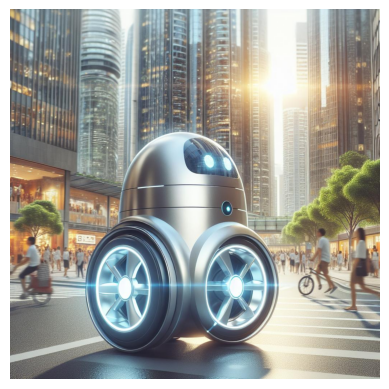

Dalle Assistant Message: /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Multi-Agents/image.jpg



'Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant'

In [18]:
generate_image("a robot in a street")

## 4 Vision Assistant

This agent is responsible for analyzing images. The output is a new prompt to be used by the image creator agent.


In [19]:
name_vs = "vision_assistant"
instructions_vs = """As a leading AI expert in image analysis, you excel at scrutinizing and 
offering critiques to refine and improve images. Your task is to thoroughly analyze an image, 
ensuring that all essential assessments are completed with precision before you provide feedback to the user. 
You have access to the local file system where the image is stored."""
tools = [{
    "type": "function",
    "function": {
        "name": "analyze_image",
        "description": "analyzes and critics an image",
        "parameters": {
            "type": "object",
            "properties": {},
            "required": []
        },
    },
}]

verbose_output = True

### Agent Initialization

Initializes the agent with the definition described above

In [20]:
vision_assistant = assistant_client.beta.assistants.create(
    name=name_vs,
    instructions=instructions_vs,
    model=assistant_deployment_name,
    tools=tools)

### Vision Assistant "analyze_image" function

This function calls the GPT4 Vision image analyzes given an image

In [21]:
def analyze_image() -> str:
    """
    Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.
    The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis.
    """
    print("*" * 75)
    print(
        "[VISION AGENT] Vision Assistant Message: Analyzing the generated image"
    )
    print("*" * 75)
    print("\nPlease wait...")

    # Create a Path object for the image file
    image_path = "image.jpg"

    # Using a context manager to open the file with Path.open()
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")
    
    content_images = [{
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }
    } for base64_image in [base64_image]]
    response = vision_client.chat.completions.create(
        model=vision_deployment_name,
        messages=[{
            "role":
            "user",
            "content": [
                {
                    "type":
                    "text",
                    "text":
                    "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                },
                *content_images,
            ],
        }],
        max_tokens=1000,
    )

    print("\033[1;31;34m")
    print("Vision Assistant Message: " + response.choices[0].message.content)
    print("\033[0m")

    return response.choices[0].message.content

### Test

In [22]:
analyze_image()

***************************************************************************
[VISION AGENT] Vision Assistant Message: Analyzing the generated image
***************************************************************************

Please wait...

Vision Assistant Message: Critique and Analysis:

This image depicts a futuristic robot with a sleek, metallic design, equipped with what appear to be illuminated wheels, situated in a bustling urban environment that showcases towering skyscrapers and a crowd of people. The image is bathed in a warm, golden light which suggests either dawn or dusk, enhancing the sense of advanced technology harmoniously integrated into everyday life. 

Positive Aspects:
- The concept is visually engaging and thought-provoking, highlighting a juxtaposition between the organic human life and the inorganic robot.
- The color palette is well-chosen, with the sunlight creating a hopeful and positive ambiance.

Areas for Improvement:
- While the design of the robot is intr

'Critique and Analysis:\n\nThis image depicts a futuristic robot with a sleek, metallic design, equipped with what appear to be illuminated wheels, situated in a bustling urban environment that showcases towering skyscrapers and a crowd of people. The image is bathed in a warm, golden light which suggests either dawn or dusk, enhancing the sense of advanced technology harmoniously integrated into everyday life. \n\nPositive Aspects:\n- The concept is visually engaging and thought-provoking, highlighting a juxtaposition between the organic human life and the inorganic robot.\n- The color palette is well-chosen, with the sunlight creating a hopeful and positive ambiance.\n\nAreas for Improvement:\n- While the design of the robot is intriguing, it could benefit from added details or distinct features that might suggest its purpose or functionality more clearly.\n- The robot appears somewhat out of scale when compared to the surrounding people, which might be intentional to convey its prom

## 5 User Proxy

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


### Proxy Assistant definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent including agents this user proxy has access to.
- Function = functions the agents has access to. send_message sends messages to the other agents and agent_name specifies which agent to communicate with

In [23]:
name_pa = "user_proxy"
agent_arr = ["dalle_assistant", "vision_assistant"]
agent_string = ""

for item in agent_arr:
    agent_string += f"{item}\n"

instructions_pa = f"""As a user proxy agent, your primary function is to streamline dialogue between the user and 
the specialized agents within this group chat. You are tasked with articulating user inquiries with clarity to the 
relevant agents and maintaining a steady flow of communication to guarantee the user's request is comprehensively addressed. Please withhold your response to the user until the task is completed, unless an issue is flagged by the respective agent or when you can provide a conclusive reply.

You have access to the local file system where files are stores. For example, you can access the image generated 
by the Dall-e assistant and send it to the Vision assistant for analysis.

You have access to the following agents to accomplish the task:
{agent_string}
If the agents above are not enough or are out of scope to complete the task, then run send_message with the name 
of the agent.

When outputting the agent names, use them as the basis of the agent_name in the send message function, even if 
the agent doesn't exist yet.

Run the send_message function for each agent name generated. 

Do not ask for followup questions, run the send_message function according to your initial input.

Plan:
1. dalle_assistant creates image 
2. vision_assistant analyzes images and creates a new prompt for dalle_assistant
3. dalle_assistant creates a new image based on the new prompt

Now take a deep breath and accomplish the plan above. Always follow the plan step by step in the exact order and 
do not ask for followup questions. Do not skip any steps in the plan, do not repeat any steps and always complete 
the entire plan in order step by step.  
The dall-e assistant can never run more than one time in a row, review your plan before running the next step.
"""

tools = [
    {
        "type": "code_interpreter"
    },
    {
        "type": "function",
        "function": {
            "name": "send_message",
            "description": "Send messages to other agents in this group chat.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The message to be sent",
                    },
                    "agent_name": {
                        "type":
                        "string",
                        "description":
                        "The name of the agent to execute the task.",
                    },
                },
                "required": ["query", "agent_name"],
            },
        },
    },
]

verbose_output = True

### Agent Initialization

Initializes the agent with the definition described above

In [24]:
user_proxy = assistant_client.beta.assistants.create(
    name=name_pa,
    instructions=instructions_pa,
    model=assistant_deployment_name,
    tools=tools)

### Proxy Assistant "send_message" function

This function calls the Assistant API to generate a main thread of communication between the agents listed in the agents_threads 

In [25]:
agents_threads: Dict[str, Dict[str, Optional[str]]] = {
    "dalle_assistant": {
        "agent": dalle_assistant,
        "thread": None
    },
    "vision_assistant": {
        "agent": vision_assistant,
        "thread": None
    },
}


# Define the send_message function with only the query parameter
def send_message(query: str, agent_name: str) -> str:
    # Check if the agent_name is in agents_threads
    if agent_name not in agent_arr:
        print(
            f"Agent '{agent_name}' does not exist. This means that the multi-agent system does not have the \
necessary agent to execute the task. *** FUTURE CODE: AGENT SWARM***"
        )
        # return None
    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # Create a new thread if user proxy and agent thread does not exist
    if not recipient_info["thread"]:
        thread_object = assistant_client.beta.threads.create()
        recipient_info["thread"] = thread_object

    # This function dispatches a message to the proper agent and it's thread
    return dispatch_message(query, recipient_info["agent"],
                            recipient_info["thread"])

## 6 The main multi-agent communication flow

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


In [26]:
def dispatch_message(message: str, agent: Assistant, thread: Thread) -> str:
    # Loops through all the agents functions to determine which function to use

    available_functions = {}
    # Iterate through each tool in the agent.tools list
    for tool in agent.tools:
        # Check if the tool has a 'function' attribute
        if hasattr(tool, "function"):
            function_name = tool.function.name
            # Attempt to retrieve the function by its name and add it to the available_functions dictionary
            if function_name in globals():
                available_functions[function_name] = globals()[function_name]
        else:
            # Handle the case where the tool does not have a 'function' attribute
            print()
            #print("This tool does not have a 'function' attribute.")
    # Draft a new message as part of the ongoing conversation.
    message = assistant_client.beta.threads.messages.create(
        thread_id=thread.id, role="user", content=message)
    # Carry out the tasks delineated in this discussion thread.
    run = assistant_client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=agent.id,
    )
    while True:
        # Await the completion of the thread execution.
        while run.status in ["queued", "in_progress"]:
            run = assistant_client.beta.threads.runs.retrieve(
                thread_id=thread.id, run_id=run.id)
            time.sleep(1)

        # If an action is necessary, initiate the appropriate function to perform the task.
        if run.status == "requires_action":
            tool_calls = run.required_action.submit_tool_outputs.tool_calls
            for _tool_call in tool_calls:
                tool_responses = []
                if (run.required_action.type == "submit_tool_outputs"
                        and run.required_action.submit_tool_outputs.tool_calls
                        is not None):
                    tool_calls = run.required_action.submit_tool_outputs.tool_calls
                    for call in tool_calls:
                        if call.type == "function":
                            if call.function.name not in available_functions:
                                raise Exception(
                                    "Function requested by the model does not exist"
                                )

                            # Assign the appropriate function to the agent for invocation.
                            function_to_call = available_functions[
                                call.function.name]
                            tool_response = function_to_call(
                                **json.loads(call.function.arguments))
                            tool_responses.append({
                                "tool_call_id": call.id,
                                "output": tool_response
                            })

            # Present the outcomes produced by the tool.
            run = assistant_client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id,
                run_id=run.id,
                tool_outputs=tool_responses)

        # if the run is completed, return the assistant message else provide error
        elif run.status == "failed":
            raise Exception("Run Failed. ", run.last_error)
        # Craft a reply from the assistant.
        else:
            messages = assistant_client.beta.threads.messages.list(
                thread_id=thread.id)

            # Transmit the response message back to the facilitating agent.
            return messages.data[0].content[0].text.value

## 7 Testing

Prompt example: 
"A ktm motorcycle in a narrow cyberpunk street, photography"

> Note: the assistants are configured to work together to complete the task. The user proxy agent is responsible for sending messages to the other agents and ensuring the task is completed successfully. It may take several iterations and several minutes to complete the task. 

In [27]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

User Query: A ktm motorcycle in a narrow cyberpunk street, photography

***************************************************************************
[DALLE3 AGENT] Dall-e3 Assistant Message: Creating the image
***************************************************************************

Please wait...


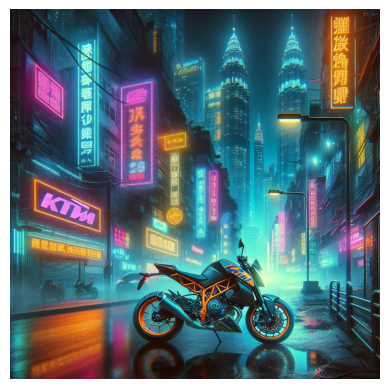

Dalle Assistant Message: /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Multi-Agents/image.jpg

***************************************************************************
[VISION AGENT] Vision Assistant Message: Analyzing the generated image
***************************************************************************

Please wait...

Vision Assistant Message: Analysis and Criticism:
The image depicts a vibrant and futuristic urban scene with a primary focus on a motorcycle in the foreground. Visually, it is rich in colour and contrast, emphasizing a neon-lit cityscape that evokes the feel of a high-tech, cyberpunk environment. Noteworthy is the juxtaposition of modern architecture in the background with more traditional, densely-packed urban buildings in the mid and foreground.

Here are some critical points to consider:

1. Lighting and Atmosphere: The image is well-executed with regards to the mood set by the lighting, especially the reflective surfaces

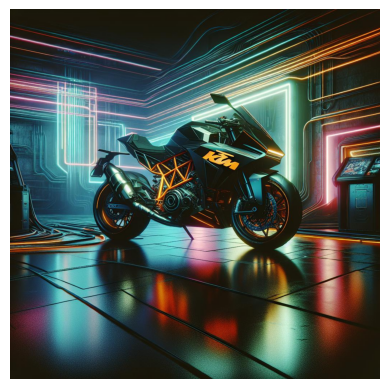

Dalle Assistant Message: /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/Multi-Agents/image.jpg



In [28]:
thread = assistant_client.beta.threads.create()

# Initiate proxy agent and the main thread.
# This thread will remain active until the task is completed and will serve as the main communication thread
# between the other agents.
user_message = input("User Query: ")
message = dispatch_message(user_message, user_proxy, thread)

## Final result

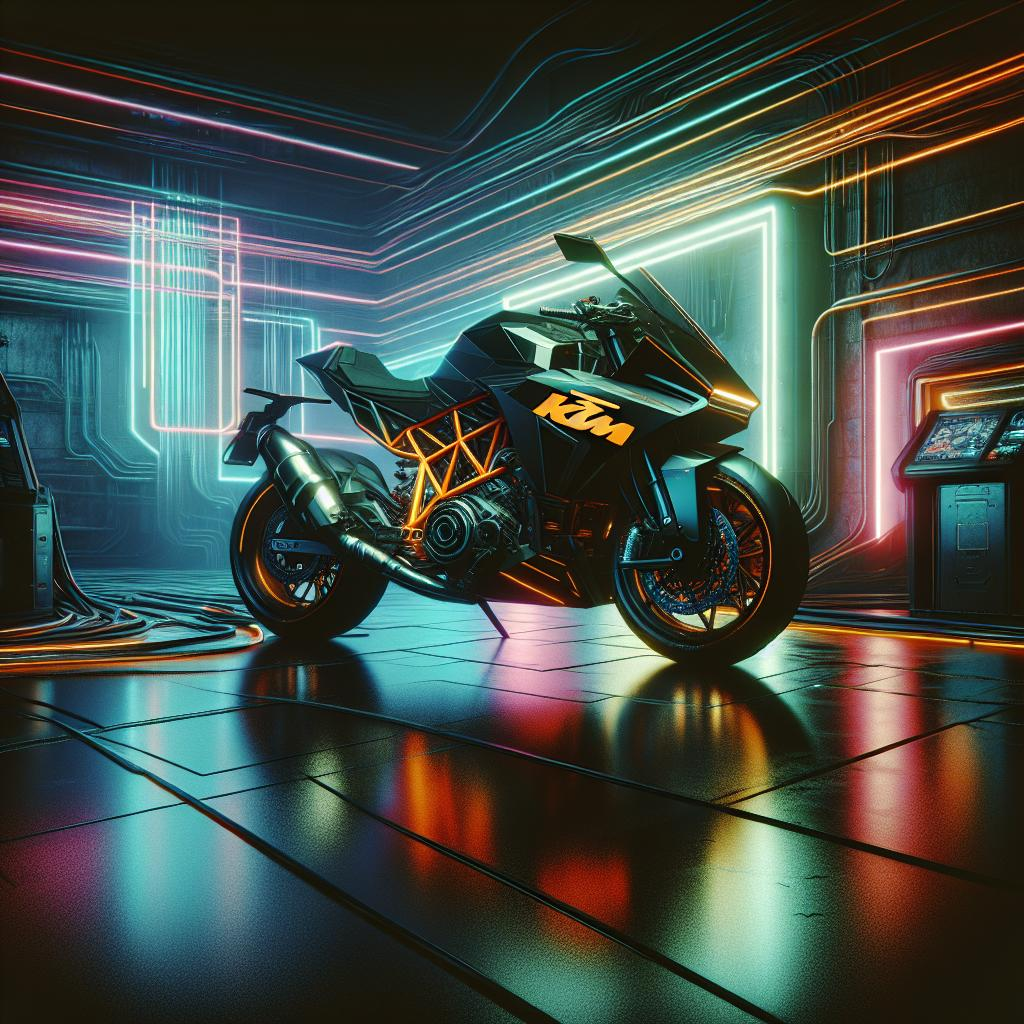

In [30]:
from IPython.display import Image

Image(filename="image.jpg")

## 8. Post Processing
To clean up all Azure Assistant threads.

In [31]:
response = assistant_client.beta.assistants.delete(user_proxy.id)
response = assistant_client.beta.assistants.delete(dalle_assistant.id)
response = assistant_client.beta.assistants.delete(vision_assistant.id)